# Turkish Delight Airlines Aircraft Analysis

## Business Understanding

"Turkish Delight Airlines," is expanding into the aviation industry with the goal of operating both commercial and private aircraft, primarily focusing on routes between Turkey and the USA. The company’s leadership is unfamiliar with the risks associated with aircraft operations and is seeking data-driven insights to make informed decisions on which aircraft models to purchase for safe and efficient operations.

## Data Understanding

In [298]:
# Import the required libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from datetime import datetime
from ydata_profiling import ProfileReport, profile_report
from project_functions.functions import transform_location
from project_functions.functions import replace_missing_values
from plotnine import *
import pytimetk as tk
from plydata.cat_tools import *


In [597]:
# Read the data
aviation_data = pd.read_csv("data/AviationData.csv", encoding='latin1')
aviation_data.shape

(88889, 31)

In [31]:
# Create a Profile Report
profile = ProfileReport(df=aviation_data)
profile.to_file("profile_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 157.81it/s]


In [598]:
# Drop the columns 
columns_to_drop = [
    'Latitude','Longitude',
    'Airport.Code','Airport.Name',
    'FAR.Description',
    'Schedule', 
    'Air.carrier', 
    'Publication.Date',
    'Accident.Number',
    'Registration.Number',
    'Aircraft.damage'
 ]

aviation_data.drop(columns_to_drop,inplace=True,axis=1)
aviation_data.shape


(88889, 20)

In [599]:
# Update columns names
aviation_data.rename(columns = lambda x : x.replace("."," ").title(),inplace=True)

In [600]:
# Injury Severity and Total Fatal Injuries have same information. Combine them into one
extracted_numbers = aviation_data['Injury Severity'].str.extract(r'\((\d+)\)').astype(float)
aviation_data['Total Fatal Injuries'] = aviation_data['Total Fatal Injuries'].fillna(extracted_numbers[0])
aviation_data['Total Fatal Injuries'] = aviation_data['Total Fatal Injuries'].fillna(0).astype(int)
aviation_data.drop(['Injury Severity'],inplace=True,axis=1)

In [601]:
# Fill missing values with 0 and convert it to type 'int'
columns_to_fill = ['Total Serious Injuries', 'Total Minor Injuries', 'Total Uninjured']
aviation_data[columns_to_fill] = aviation_data[columns_to_fill].fillna(0).astype(int)

In [602]:
# Change the Event Date to datetime
aviation_data['Event Date'] = pd.to_datetime(aviation_data['Event Date'])

In [603]:
# Adjust the value of the Location column
aviation_data['Location'] = aviation_data.apply(transform_location, axis=1)

In [604]:
# Re-format the Country and Location columns
aviation_data['Country'] = aviation_data['Country'].apply(replace_missing_values)
aviation_data['Country'] = aviation_data['Country'].str.title()
aviation_data['Location'] = aviation_data['Location'].apply(replace_missing_values)

In [605]:
# Update state names to full names
state_codes = pd.read_csv("data/USState_Codes.csv")
state_codes_dict = dict(zip(state_codes['Abbreviation'], state_codes['US_State']))

aviation_data['Location'] = aviation_data['Location'].map(state_codes_dict )


In [606]:
# Update the Engine Type and Aircraft Category columns
aviation_data['Engine Type'] = aviation_data['Engine Type'].apply(replace_missing_values)
aviation_data['Aircraft Category'] = aviation_data.apply(
    lambda row: row['Engine Type'] if pd.isna(row['Aircraft Category']) and row['Engine Type'] in ['Turbo Fan', 'Geared Turbofan'] else row['Aircraft Category'],
    axis=1
)


In [607]:
aviation_data['Aircraft Category'] = aviation_data['Aircraft Category'].replace('Turbo Fan', 'Airplane')
aviation_data = aviation_data[aviation_data['Aircraft Category'] == 'Airplane']

In [608]:
aviation_data.drop(['Engine Type'],inplace=True,axis=1)


In [609]:
# Filter the data based on the number of engines
aviation_data['Number Of Engines'] = aviation_data['Number Of Engines'].fillna(0).astype(int)
aviation_data = aviation_data[aviation_data['Number Of Engines'].isin([2, 3, 4])]

In [610]:
# Format the Make column
aviation_data['Make'] = aviation_data['Make'].str.title()

In [611]:
# Filter the data based on the year (20 years)
max_date = aviation_data['Event Date'].max()
aviation_data = aviation_data[aviation_data['Event Date'] > max_date - pd.DateOffset(years=20)]

In [612]:
# Clean the missing values in Weather Condition and Broad Pahase of Flight columns
aviation_data['Weather Condition'] = aviation_data['Weather Condition'].apply(replace_missing_values)
aviation_data['Broad Phase Of Flight'] = aviation_data['Broad Phase Of Flight'].apply(replace_missing_values)
aviation_data['Purpose Of Flight']= aviation_data['Purpose Of Flight'].apply(replace_missing_values)

In [613]:
# Clean the missing values in Report Status column and save it to a csv file(Prepared for the LLM to create categories)
aviation_data['Report Status'] = aviation_data['Report Status'].apply(replace_missing_values)
aviation_data['Report Status'].to_csv('data/report_status.csv', index=False)

In [614]:
aviation_data.shape

(3337, 18)

In [615]:
# Retrieve the categories for the cause of accidents
category_df = pd.read_csv('data/categorized_accident_reasons_llm.csv')
category_df

,Report Status,Category
0,Probable Cause,Pilot Error
1,Probable Cause,Pilot Error
2,Probable Cause,Pilot Error
3,Probable Cause,Pilot Error
4,Probable Cause,Pilot Error
...,...,...
3332,Unknown,Other
3333,Unknown,Other
3334,Unknown,Other
3335,Unknown,Other


In [616]:
# Merge the category_df and aviation_data
aviation_data['temp_index'] = range(len(aviation_data))
category_df['temp_index'] = range(len(category_df))
merged_df = aviation_data.merge(category_df, on='temp_index', suffixes=('', '_category'))
merged_df



,Event Id,Investigation Type,Event Date,Location,Country,Aircraft Category,Make,Model,Amateur Built,Number Of Engines,...,Total Fatal Injuries,Total Serious Injuries,Total Minor Injuries,Total Uninjured,Weather Condition,Broad Phase Of Flight,Report Status,temp_index,Report Status_category,Category
0,20021220X05625,Accident,2002-12-16,Washington,United States,Airplane,Hawker Siddeley,DH-125,No,2,...,0,0,0,3,IMC,Landing,Probable Cause,0,Probable Cause,Pilot Error
1,20030131X00137,Incident,2002-12-17,Guam,United States,Airplane,Airbus Industrie,330-301,No,2,...,0,0,0,115,IMC,Approach,Probable Cause,1,Probable Cause,Pilot Error
2,20030106X00019,Accident,2002-12-26,Florida,United States,Airplane,Piper,PA-30,No,2,...,0,0,0,1,VMC,Standing,Probable Cause,2,Probable Cause,Pilot Error
3,20030115X00070,Incident,2003-01-04,Colorado,United States,Airplane,Hawker Siddeley,HS-125-700A,No,2,...,0,0,0,6,VMC,Standing,Probable Cause,3,Probable Cause,Pilot Error
4,20030109X00039,Accident,2003-01-06,Ohio,United States,Airplane,Embraer,ERJ-145LR,No,2,...,0,0,0,50,IMC,Landing,Probable Cause,4,Probable Cause,Pilot Error
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,20221202106398,Accident,2022-11-30,Virginia,United States,Airplane,Gates Lear Jet Corp.,36,No,2,...,0,0,0,3,VMC,Unknown,Unknown,3332,Unknown,Other
3333,20221209106436,Accident,2022-12-01,NaN,Cuba,Airplane,Learjet,35,No,2,...,0,0,0,4,VMC,Unknown,Unknown,3333,Unknown,Other
3334,20221211106438,Accident,2022-12-09,Georgia,United States,Airplane,Piper,PA-44,No,2,...,0,1,0,0,VMC,Unknown,Unknown,3334,Unknown,Other
3335,20221213106455,Accident,2022-12-13,Montana,United States,Airplane,Piper,PA42,No,2,...,0,0,0,1,Unknown,Unknown,Unknown,3335,Unknown,Other


In [619]:
merged_df['Category'] = merged_df.apply(
    lambda row: row['Report Status_category'] if row['Report Status_category'] == 'Probable Cause' else row['Category'],
    axis=1
)
merged_df.head()

,Event Id,Investigation Type,Event Date,Location,Country,Aircraft Category,Make,Model,Amateur Built,Number Of Engines,...,Total Fatal Injuries,Total Serious Injuries,Total Minor Injuries,Total Uninjured,Weather Condition,Broad Phase Of Flight,Report Status,temp_index,Report Status_category,Category
0,20021220X05625,Accident,2002-12-16,Washington,United States,Airplane,Hawker Siddeley,DH-125,No,2,...,0,0,0,3,IMC,Landing,Probable Cause,0,Probable Cause,Probable Cause
1,20030131X00137,Incident,2002-12-17,Guam,United States,Airplane,Airbus Industrie,330-301,No,2,...,0,0,0,115,IMC,Approach,Probable Cause,1,Probable Cause,Probable Cause
2,20030106X00019,Accident,2002-12-26,Florida,United States,Airplane,Piper,PA-30,No,2,...,0,0,0,1,VMC,Standing,Probable Cause,2,Probable Cause,Probable Cause
3,20030115X00070,Incident,2003-01-04,Colorado,United States,Airplane,Hawker Siddeley,HS-125-700A,No,2,...,0,0,0,6,VMC,Standing,Probable Cause,3,Probable Cause,Probable Cause
4,20030109X00039,Accident,2003-01-06,Ohio,United States,Airplane,Embraer,ERJ-145LR,No,2,...,0,0,0,50,IMC,Landing,Probable Cause,4,Probable Cause,Probable Cause


In [620]:
aviation_data = merged_df.drop(columns=['Report Status_category', 'temp_index'])

In [632]:
aviation_data['Category'] = aviation_data['Category'].apply(replace_missing_values)

In [634]:

aviation_data.drop('Event Id', axis=1, inplace=True)

In [635]:
aviation_data.to_csv('data/aviation_data_cleaned.csv', index=False)

## Exploratory Data Analysis

#### Analyze the cause of mechanical failures in aircrafts

In [636]:
aviation_data = pd.read_csv('data/aviation_data_cleaned.csv')

In [640]:
# change all nan values in the Category column to 'Unknown'
aviation_data['Category'] = aviation_data['Category'].fillna('Unknown')

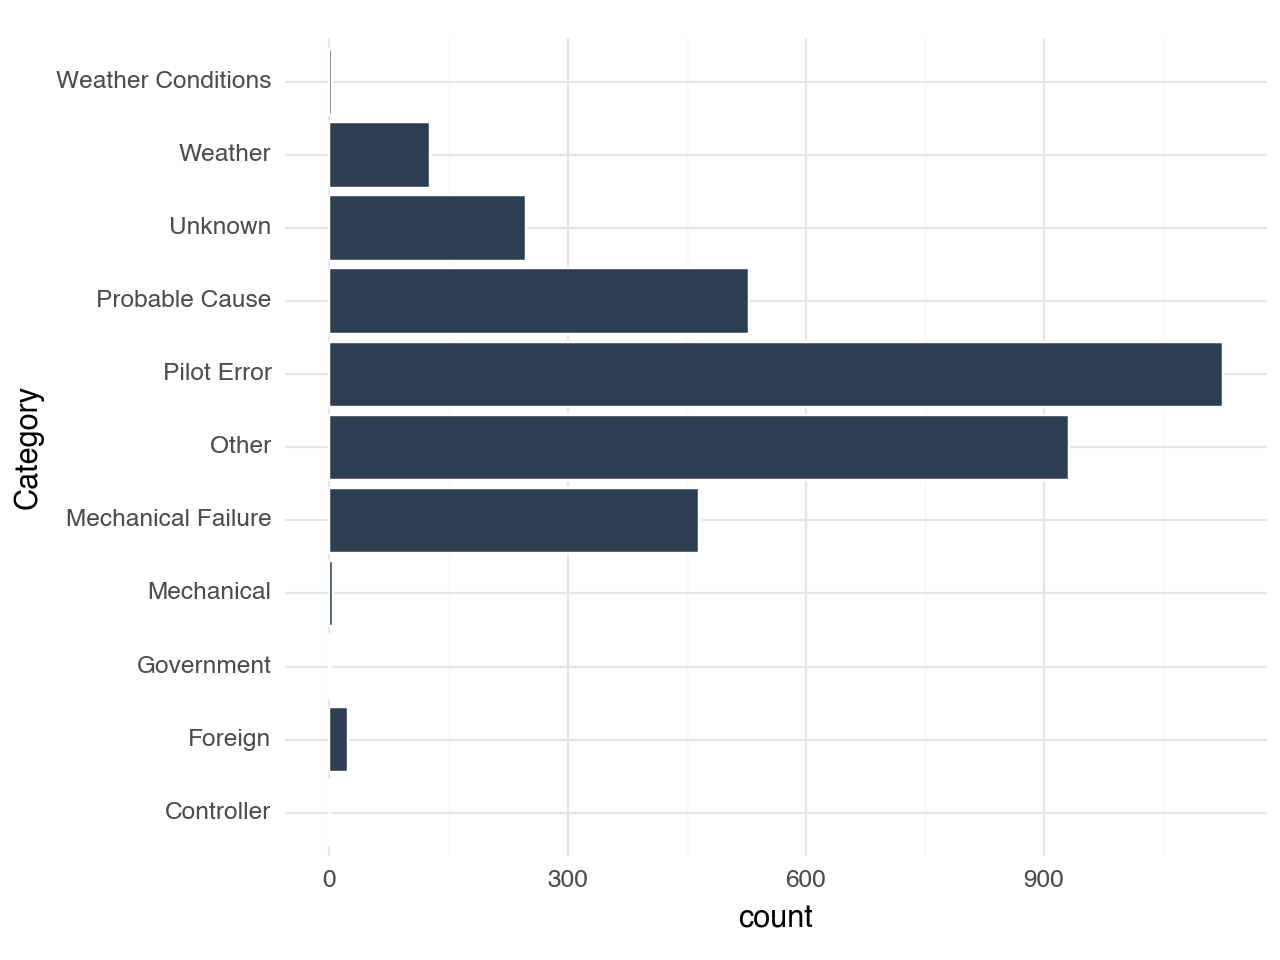

<Figure Size: (640 x 480)>

In [646]:
(ggplot(aviation_data, aes(x='Category')) +
    geom_bar(fill='#2c3e50',color='white') +
    coord_flip() + 
    theme(axis_text_x=element_text(rotation=45, hjust=1)) +\
    theme_minimal()
)

In [659]:
pivot_table = aviation_data.pivot_table(index='Make', columns='Category', aggfunc='size', fill_value=0).sort_values(by='Mechanical Failure', ascending=False)
pivot_table['Percentage of Mechanical Failures'] = pivot_table['Mechanical Failure'] / pivot_table.sum(axis=1) * 100
pivot_table = pivot_table.reset_index()
#pivot_table['Make'] = pivot_table['Make'].apply(lambda x: x if x in ['Cessna', 'Piper', 'Beech', 'Aero Commander'] else 'Other')
pivot_table

Category,Make,Controller,Foreign,Government,Mechanical,Mechanical Failure,Other,Pilot Error,Probable Cause,Unknown,Weather,Weather Conditions,Percentage of Mechanical Failures
0,Cessna,0,1,1,0,114,121,226,76,20,7,0,20.141343
1,Beech,0,1,1,0,66,85,232,57,23,7,0,13.983051
2,Boeing,0,6,0,2,66,236,106,110,8,50,1,11.282051
3,Piper,0,0,0,0,58,121,193,59,30,4,0,12.473118
4,Bombardier Inc,0,0,0,0,18,19,18,0,2,5,0,29.032258
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,Hawker Beechcraft,0,0,0,0,0,2,4,0,1,1,0,0.000000
192,Hawker Beech,0,0,0,0,0,1,0,0,0,0,0,0.000000
193,Aerospatiale,0,0,0,0,0,1,0,0,0,0,0,0.000000
194,Gulfstream American Corp,0,1,0,0,0,0,0,0,0,0,0,0.000000


In [712]:
# Data Preparation
pivot_table = pivot_table\
    .melt(
        id_vars='Make', 
        value_vars=['Mechanical Failure', 'Pilot Error', 'Weather Conditions','Probable Cause', 'Other'], 
        var_name='Category', 
        value_name='Count'
        )
    
pivot_table = pivot_table.sort_values(by='Count', ascending=False)
pivot_table





ValueError: value_name (Count) cannot match an element in the DataFrame columns.

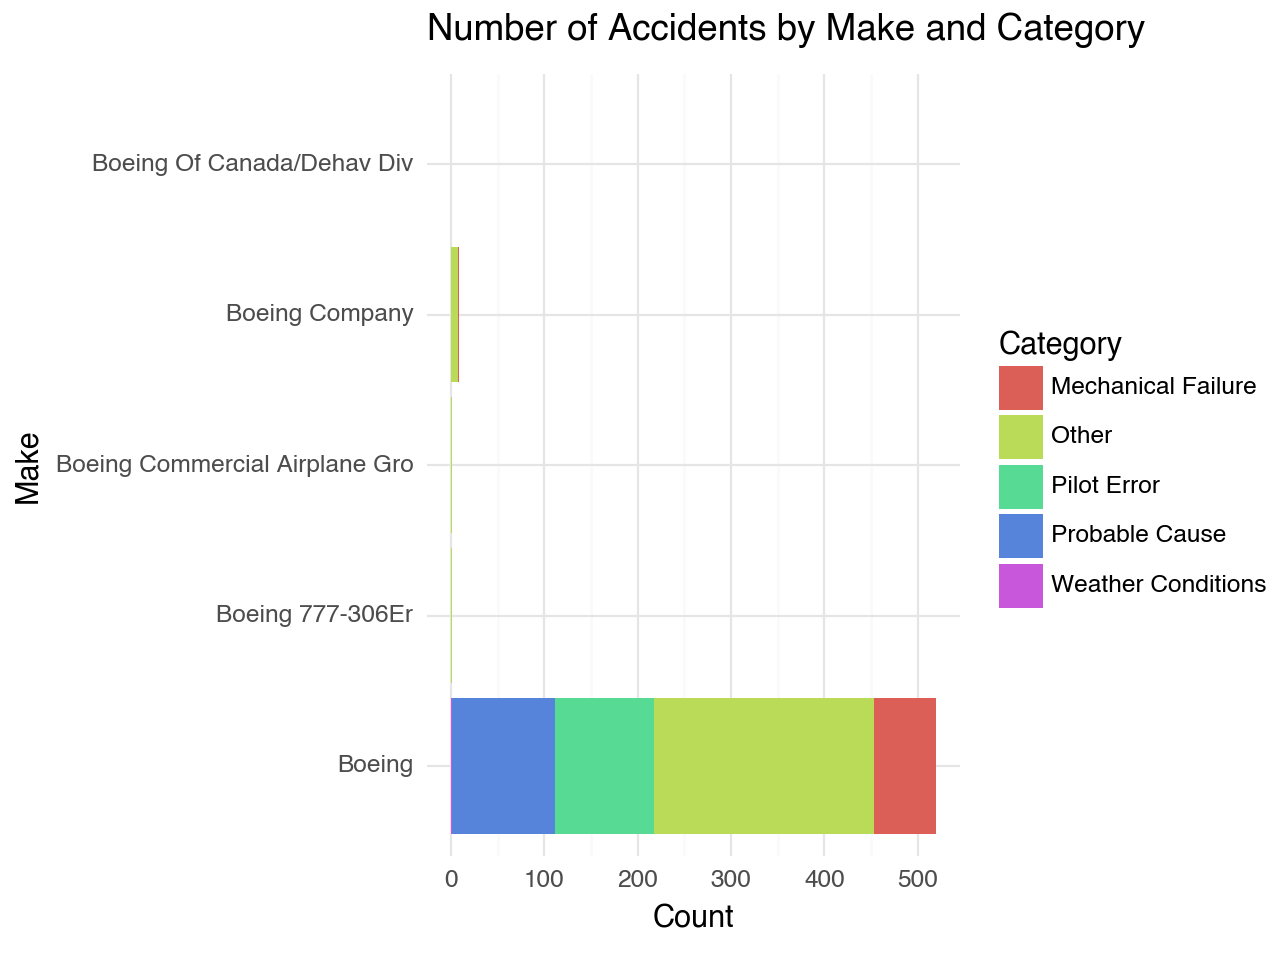

<Figure Size: (640 x 480)>

In [715]:
# Visualization of the data which is Make starts with 'Boeing'
pivot_table = pivot_table[pivot_table['Make'].str.startswith('Boeing')]
(
    ggplot(pivot_table, aes(x='Make', y='Count', fill='Category')) +
    geom_col() +
    coord_flip() + 
    labs(title='Number of Accidents by Make and Category', x='Make', y='Count') +
    theme_minimal()
)

In [722]:
# show the data which is Make starts with 'Boeing' ignore Nana values
aviation_data['Make'] = aviation_data['Make'].apply(replace_missing_values)
boeing = aviation_data[aviation_data['Make'].str.startswith('Boeing')]
# group the boing data by make and model and show the total row numbers
boeing = boeing.groupby(['Make', 'Model']).size().reset_index(name='Count')
# cretae a pivot table
pivot_table = boeing.pivot_table(index='Make', columns='Model', values='Count', fill_value=0)


In [728]:
pivot_table.sort_values('Count',ascending=False)

,Make,Model,Count
45,Boeing,737,109.0
575,Boeing,767,33.0
345,Boeing,747,30.0
475,Boeing,757,25.0
695,Boeing,777,20.0
...,...,...,...
751,Boeing 777-306Er,777-232,0.0
752,Boeing Commercial Airplane Gro,777-232,0.0
753,Boeing Company,777-232,0.0
754,Boeing Of Canada/Dehav Div,777-232,0.0


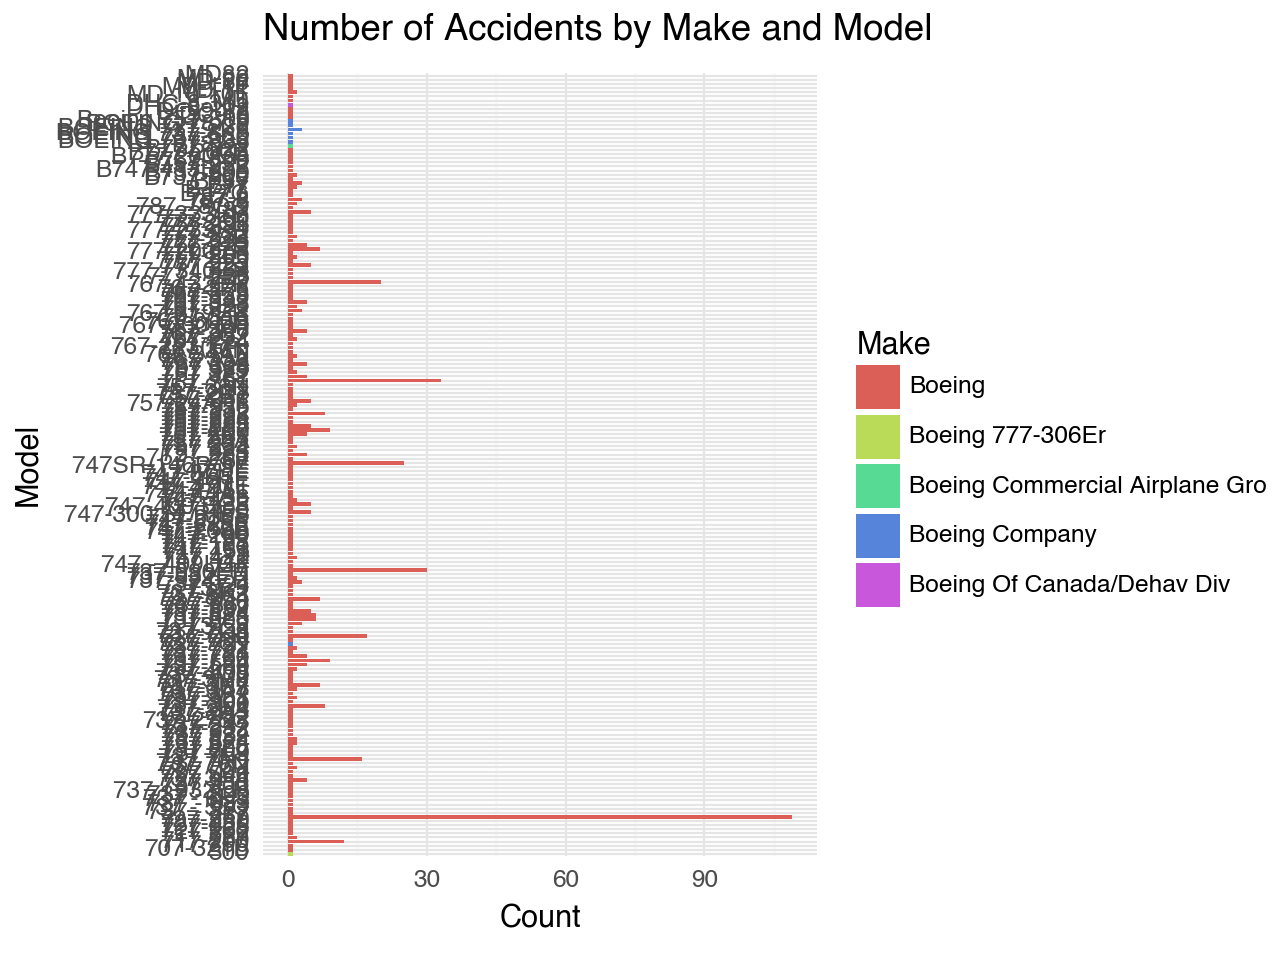

<Figure Size: (640 x 480)>

In [724]:
# create a bar chart for the pivot table
pivot_table = pivot_table.reset_index()
pivot_table = pivot_table.melt(id_vars='Make', var_name='Model', value_name='Count')
pivot_table = pivot_table.sort_values(by='Count', ascending=False)
(
    ggplot(pivot_table, aes(x='Model', y='Count', fill='Make')) +
    geom_col() +
    coord_flip() + 
    labs(title='Number of Accidents by Make and Model', x='Model', y='Count') +
    theme_minimal()
)

#### Create scoring for Injury Categories

In [662]:
#aviation_data_filtered_by_top_risky_make = aviation_data[~aviation_data['Make'].isin(['Cessna', 'Piper', 'Beech', 'Aero Commander'])]
aviation_data['Weighted Score'] = aviation_data['Total Fatal Injuries'] * 5\
+ aviation_data['Total Serious Injuries'] * 3\
+ aviation_data['Total Minor Injuries'] * 2


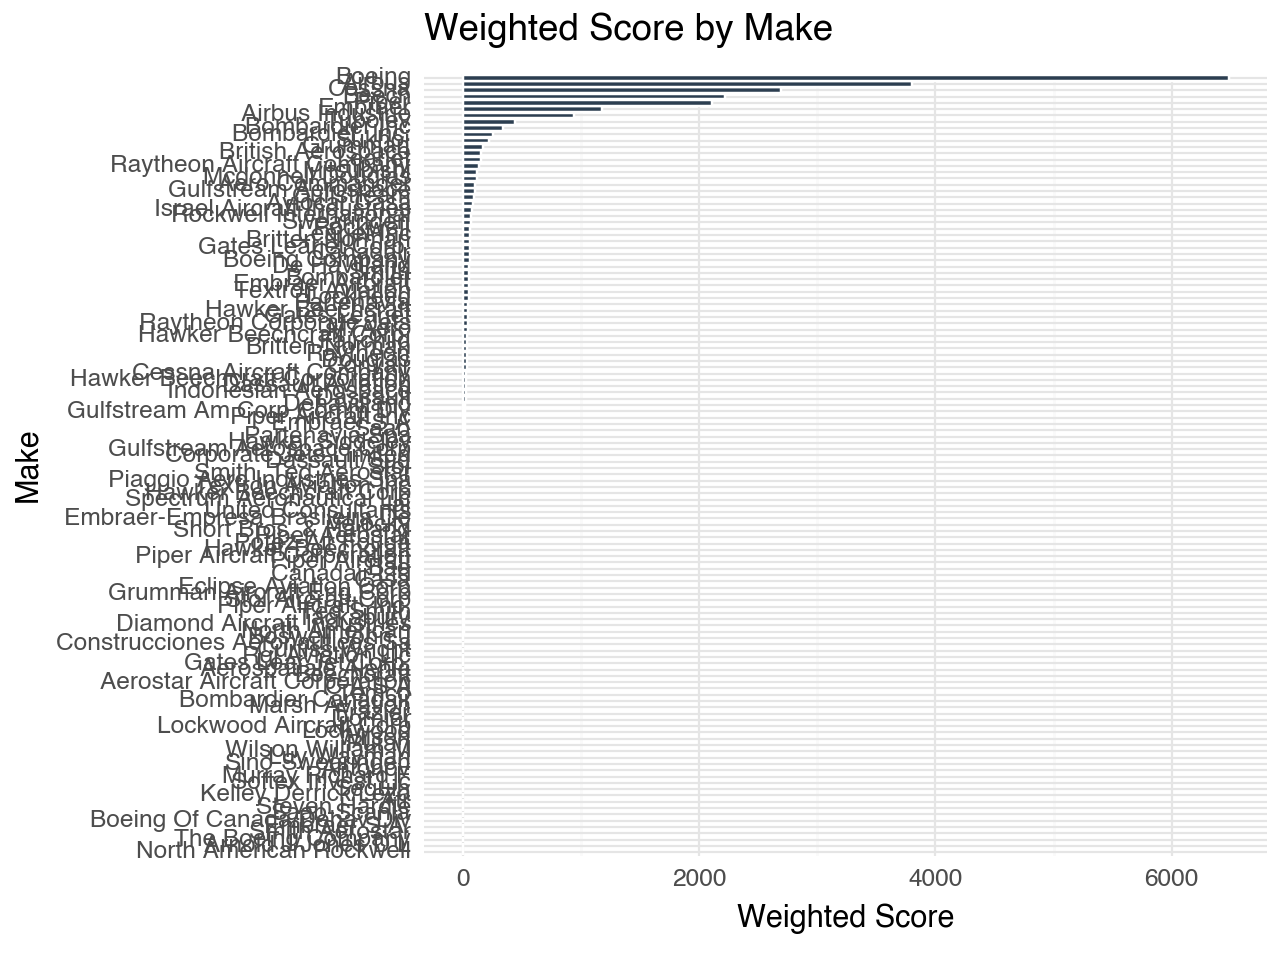

<Figure Size: (640 x 480)>

In [663]:
temp_df = aviation_data.groupby('Make')['Weighted Score'].sum().sort_values(ascending=False).reset_index()
temp_df = temp_df[temp_df['Weighted Score'] != 0]\
            .sort_values(by='Weighted Score', ascending=False)\
            .assign(Make = lambda x : cat_reorder(x['Make'],x['Weighted Score']))
(
    ggplot(temp_df, aes(x='Make', y='Weighted Score')) +
    geom_col(fill='#2c3e50',color='white') +
    coord_flip() + 
    theme(axis_text_x=element_text(rotation=45, hjust=1)) +
    labs(title='Weighted Score by Make', x='Make', y='Weighted Score') +
    theme_minimal()
)

#### Analyse the timeline for the accidents by Manufacturer

In [292]:
aviation_data_filtered_by_least_risky_injured_score = aviation_data['Make'].isin(temp_df['Make'])

In [669]:
aviation_data['Event Date'] = pd.to_datetime(aviation_data['Event Date'], errors='coerce')


In [671]:
# Calculate the maximum date for each 'Make' and 'Model'
max_date = datetime.today()
date_df = aviation_data.groupby(['Make', 'Model'])['Event Date'].max().sort_values(ascending=False).reset_index()

# Calculate the number of days since the last accident
date_df['Days Since Last Accident'] = (max_date - date_df['Event Date']).dt.days

# Sort the DataFrame by 'Days Since Last Accident' in descending order
date_filtered_df = date_df.sort_values(by='Days Since Last Accident', ascending=False)

# Display the resulting DataFrame
date_filtered_df

,Make,Model,Event Date,Days Since Last Accident
1162,Hawker Siddeley,DH-125,2002-12-16,7956
1161,Airbus Industrie,330-301,2002-12-17,7955
1160,Embraer,ERJ-145LR,2003-01-06,7935
1159,Mcdonnell Douglas,MD-11-C,2003-01-14,7927
1158,Canadair,CRJ-600,2003-02-14,7896
...,...,...,...,...
4,Gates Lear Jet Corp.,36,2022-11-30,667
3,Learjet,35,2022-12-01,666
2,Piper,PA-44,2022-12-09,658
1,Piper,PA42,2022-12-13,654


In [692]:
new = date_filtered_df\
    .groupby('Make')\
    .summarize_by_time(
        date_column = 'Event Date',
        value_column = 'Days Since Last Accident',
        freq = 'Y',
        agg_func = 'sum',
        wide_format = False
    )


#df_final = new.sort_values(by='Days Since Last Accident', ascending=False)


In [705]:
df2_final = new
df2_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031 entries, 0 to 1030
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Make                      1031 non-null   object        
 1   Event Date                1031 non-null   datetime64[ns]
 2   Days Since Last Accident  1031 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 24.3+ KB


In [706]:
# Ensure 'Event Date' is parsed as datetime
#df2_final['Event Date'] = pd.to_datetime(df2_final['Event Date'], errors='coerce')

# Extract the year from 'Event Date'
df2_final['Event Date'] = df2_final['Event Date'].dt.year

df2_final



,Make,Event Date,Days Since Last Accident
0,Aero Commander,2006,6766
1,Aero Commander,2007,0
2,Aero Commander,2008,11903
3,Aero Commander,2009,5557
4,Aero Commander,2010,10171
...,...,...,...
1026,Tupolev,2010,5284
1027,United Consultants,2022,802
1028,Velocity,2021,1319
1029,Wilson,2016,2974


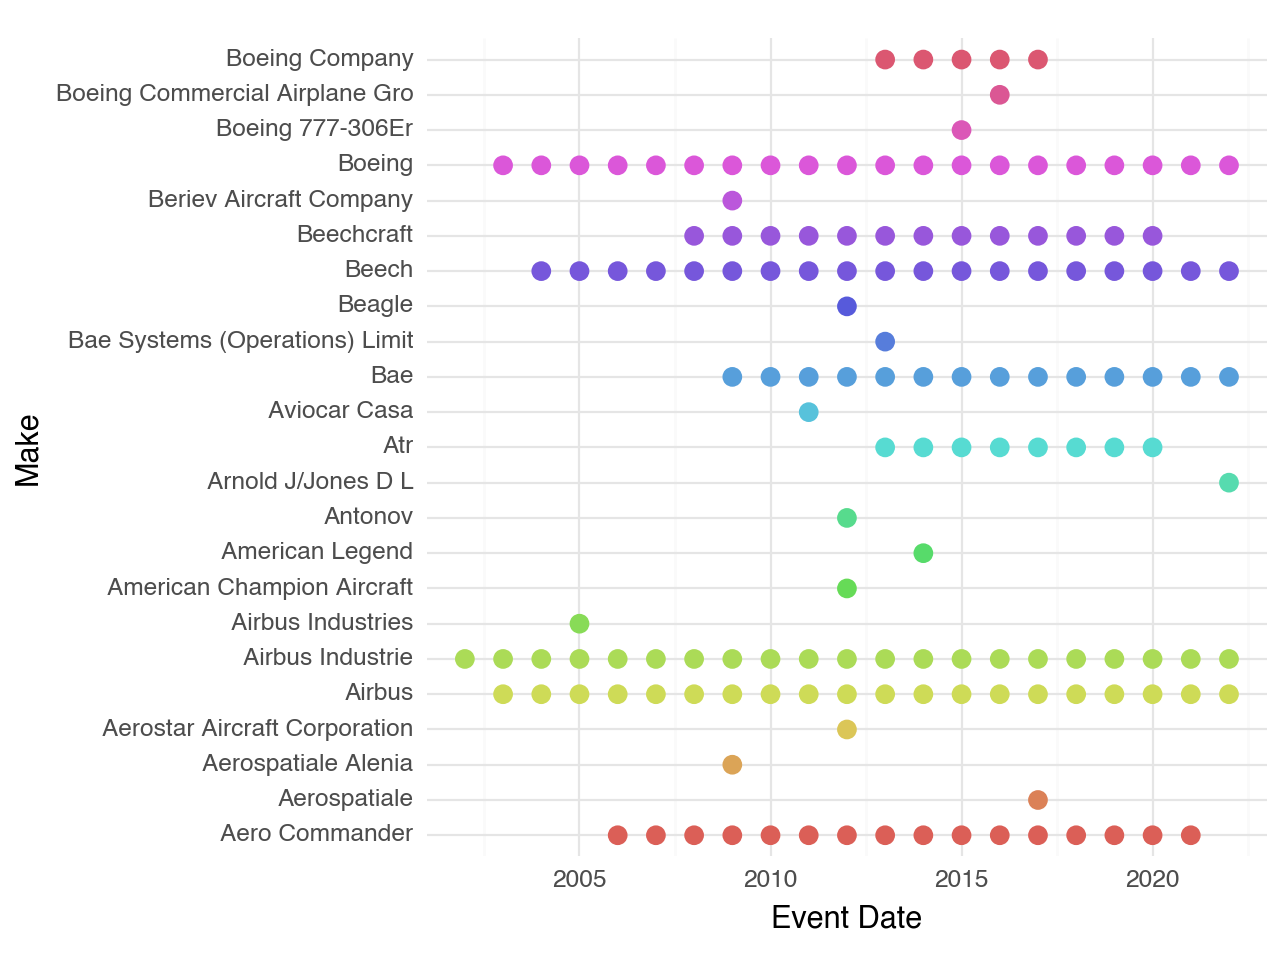

<Figure Size: (640 x 480)>

In [711]:
# Plotting with ggplot
from plotnine import ggplot, aes, geom_point, theme_minimal, theme, element_rect, element_text

ggplot(
    mapping = aes('Event Date', 'Make', color='Make'),
    data = df2_final.head(150)
) + geom_point(size=3) + theme_minimal() + theme(
    strip_background = element_rect(fill = "#2c3e50"),
    strip_text       = element_text(color = "white"),
    legend_position = 'none',
    #figure_size = (12,6),
    subplots_adjust = {'wspace' : 0.25},
    plot_title = element_text(ha='center')
)


# SUMMARY

Cleaning

- Aircraft Category : Airplane
- Engine Type : Turbo Fan, Geared Turbofan
- Number of Engine : 2 >
- Report filtered to 20 yrs from max date
- Categorize the Status and focus on Machanical Failures

Analyze

- Eliminate the Mechanical Failures Causes
- Create a risk score for the Fatal, Serious, Minor injuries and filter it
- Focus on 'days since last accident' and determine how often each make has recurring accidents annually.

### Outcome Data

The outcome dataset also includes records from October 2013 to August 2020, and includes a variety of outcome types.

## Conclusions

This analysis leads to three recommendations for improving operations of the Austin Animal Center:

- **Engage in targeted outreach campaigns for dogs that have been sheltered at AAC for more than 30 days.** While most dogs will have been placed after 30 days, this may help reduce the number of dogs that end up having extended stays, potentially requiring many more months of care.
- **Reduce current spending until the numbers of intakes and sheltered animals return to normal.** Given the reduced activity during this period, AAC should consider ways to temporarily reduce costs by changing space utilization or staffing.
- **Hire seasonal staff and rent temporary space for May through December.** To accommodate the high volume of intakes and number of sheltered animals in the spring and fall, AAC should leverage seasonal resources, rather than full-year ones. This will allow AAC to cut back on expenditures during the months when there is lower

### Next Steps

Further analyses could yield additional insights to further improve operations at AAC:

- **Better prediction of animals that are likely to have long stays.** This modeling could use already available data, such as breed and intake condition.
- **Model need for medical support.** This modeling could predict the need for specialized personnel to address animals' medical needs, including neutering, using intake condition and sex data.
- **Predicting undesirable outcomes.** This modeling could identify animals that are more likely to have undesirable outcomes (e.g. Euthanasia) for targeted medical support or outreach.